In [21]:
# Cell 1: Imports
import os
import sys

import Utils
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import shap

from Utils import visualization as viz
from Utils import model
from Utils import explainer

import importlib
importlib.reload(Utils.model)
importlib.reload(Utils.explainer)
importlib.reload(Utils.visualization)

<module 'Utils.visualization' from '/home/ferazzio/breast-cancer-pam50-xai-classification/Utils/visualization.py'>

In [6]:
# Loading Dataset
df = model.load_dataset(ide="local-linux")

In [7]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
# Label Targeting and Feature Selection
label = df.columns[-1]
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_cols = [c for c in numeric_cols if c != label]

# Preparing Feature Matrix and Target Vector
X = df[feature_cols].values
y_raw = df[label].values

# Label Encoding the Target Variable
le = LabelEncoder()
y = le.fit_transform(df[label])

class_names = le.classes_

In [9]:
# Splitting the Dataset into Training and Val-Test Sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Further Splitting Val-Test Set into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                y_val_test,
                                                test_size=0.5,
                                                stratify=y_val_test,
                                                random_state=42)

In [10]:
# Preprocessing
X_train_s, X_val_s, _, _ = model.preprocess_data(X_train, X_val)

In [12]:
nn_model = model.train_neural_network(X_train=X_train_s,
                                      y_train=y_train,
                                      X_val=X_val_s,
                                      y_val=y_val,
                                      batch_size=16,
                                      learning_rate=0.001)

Training Neural Network (Black-Box)...
  Architecture: [256, 128, 64], Dropout: 0.3
  Epochs: 100, Batch Size: 16, LR: 0.001
  Device: cuda
  Epoch [10/100] - Train Loss: 0.1504, Val Loss: 0.4055, Val Acc: 0.8741
  Epoch [20/100] - Train Loss: 0.0559, Val Loss: 0.3004, Val Acc: 0.8951
  Early stopping at epoch 27
Training Neural Network Selesai.


In [13]:
model.evaluate(nn_model, X_val_s, y_val, class_names, "Neural Network")


--- Evaluasi Performa: Neural Network ---
Akurasi: 0.8951

Laporan Klasifikasi:
              precision    recall  f1-score   support

       Basal       0.95      0.95      0.95        21
        Her2       0.73      0.80      0.76        10
        LumA       0.92      0.91      0.91        65
        LumB       0.79      0.79      0.79        29
      Normal       1.00      1.00      1.00        18

    accuracy                           0.90       143
   macro avg       0.88      0.89      0.88       143
weighted avg       0.90      0.90      0.90       143



0.8951048951048951

In [19]:
explainer_nn, shap_values_nn = explainer.compute_shap_neural_network(
    nn_model, X_train_s, X_val_s,
    n_background=50, n_samples=20
)

--- Menghitung SHAP (Neural Network)... ---
Background samples: 50, Target samples: 20
Mencoba DeepExplainer...
✅ DeepExplainer berhasil.
✅ Perhitungan SHAP Neural Network selesai. Kelas terdeteksi: 5


Generasi Feature Importance Plot untuk Neural Network...


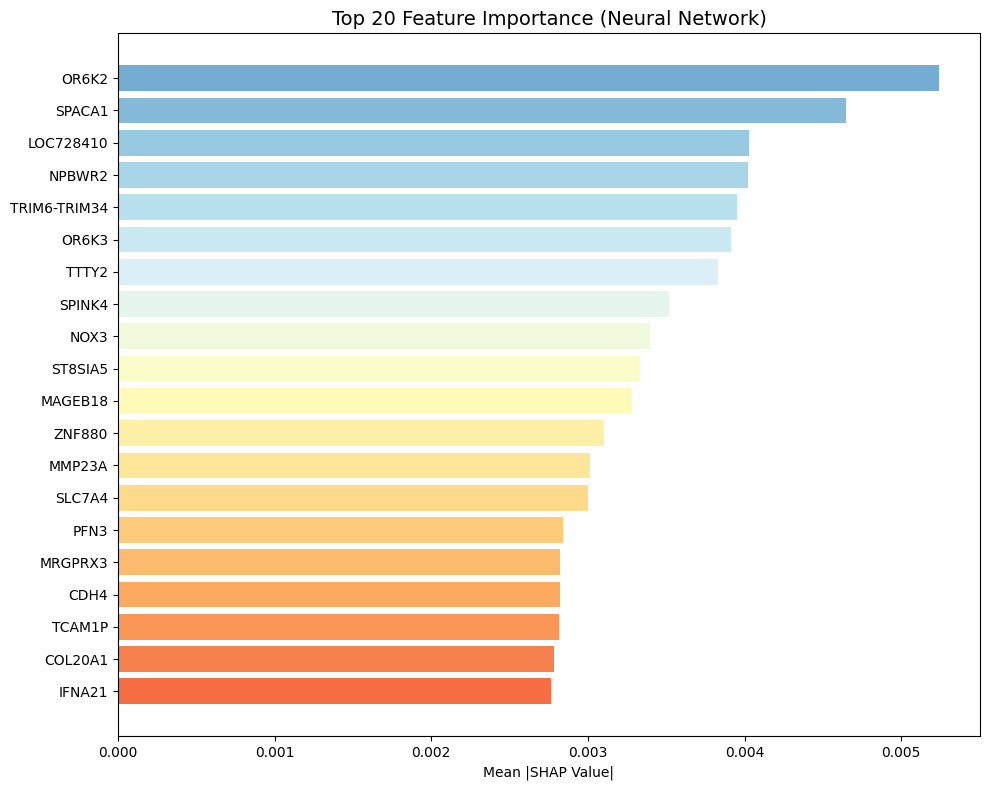

Generasi Plot Summary untuk: Basal (Neural Network)...


/home/ferazzio/breast-cancer-pam50-xai-classification/Utils/visualization.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(matrix, X_data, feature_names=feature_names, show=False, max_display=max_display)


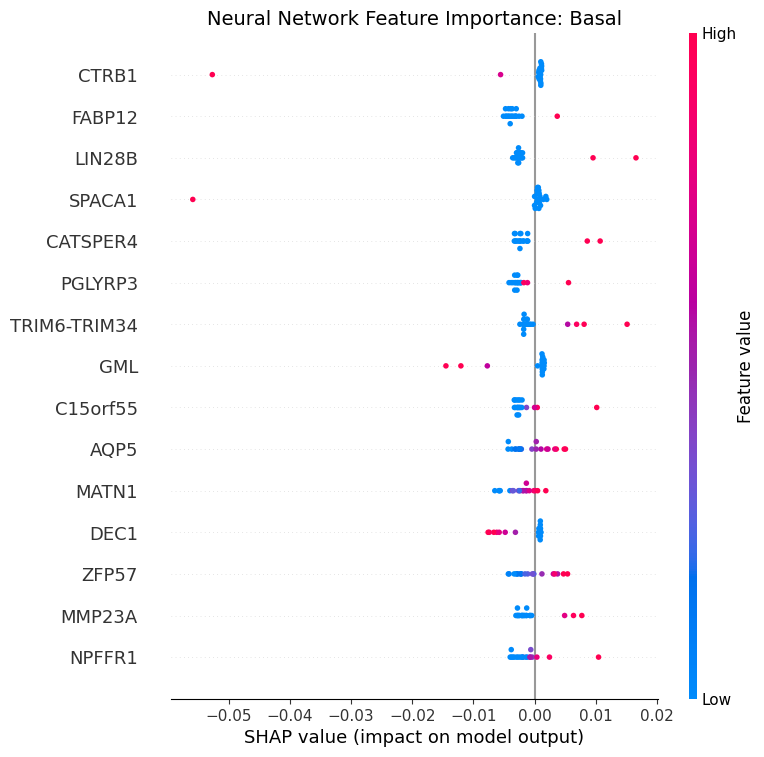

Generasi Plot Summary untuk: Her2 (Neural Network)...


/home/ferazzio/breast-cancer-pam50-xai-classification/Utils/visualization.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(matrix, X_data, feature_names=feature_names, show=False, max_display=max_display)


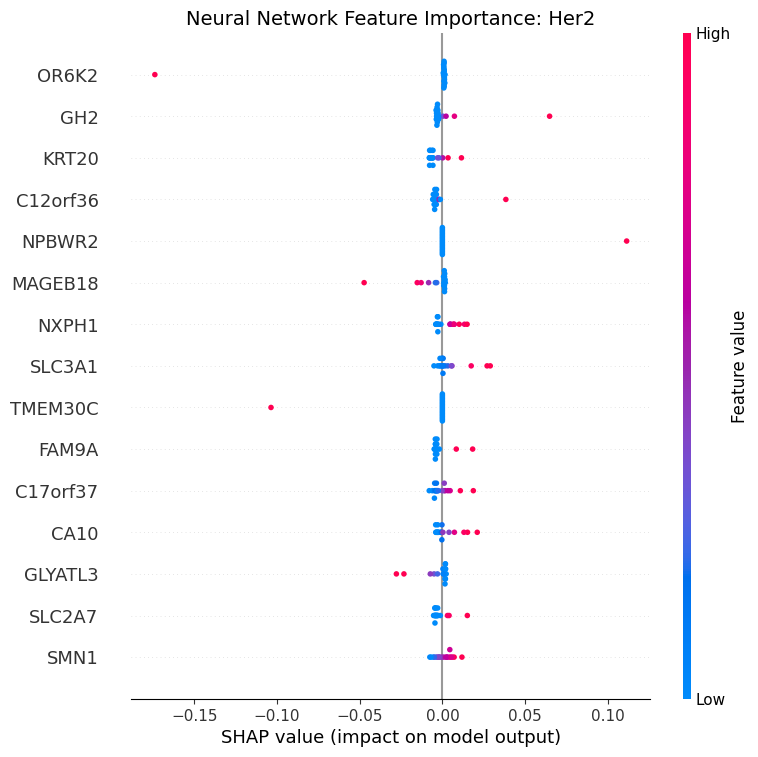

Generasi Plot Summary untuk: LumA (Neural Network)...


/home/ferazzio/breast-cancer-pam50-xai-classification/Utils/visualization.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(matrix, X_data, feature_names=feature_names, show=False, max_display=max_display)


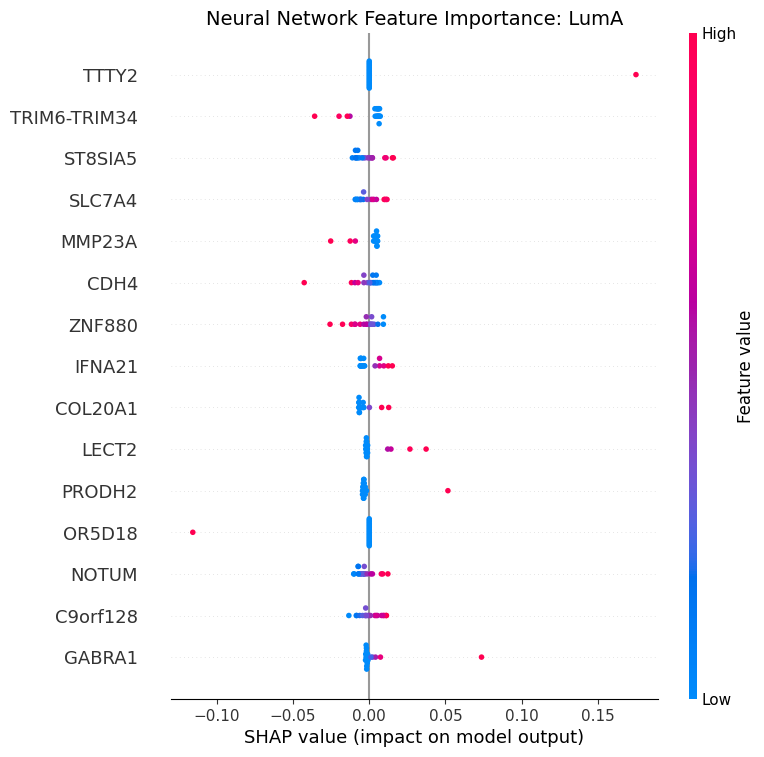

Generasi Plot Summary untuk: LumB (Neural Network)...


/home/ferazzio/breast-cancer-pam50-xai-classification/Utils/visualization.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(matrix, X_data, feature_names=feature_names, show=False, max_display=max_display)


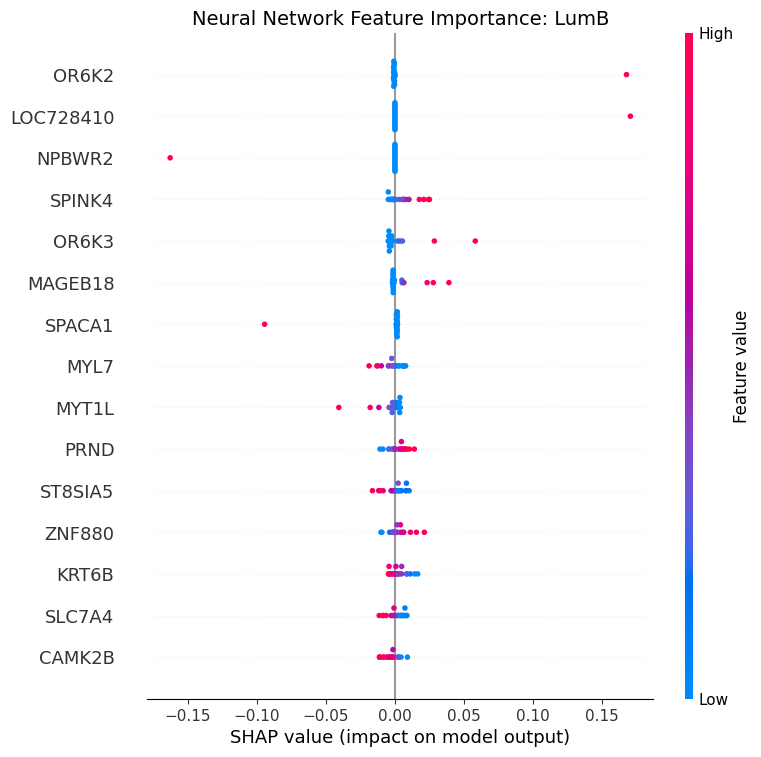

Generasi Plot Summary untuk: Normal (Neural Network)...


/home/ferazzio/breast-cancer-pam50-xai-classification/Utils/visualization.py:159: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(matrix, X_data, feature_names=feature_names, show=False, max_display=max_display)


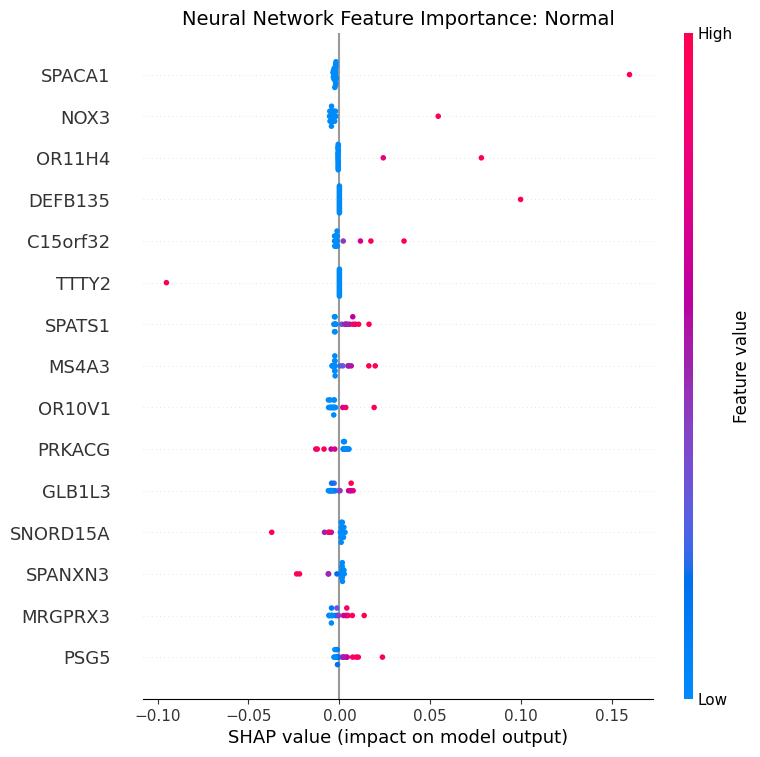

In [22]:
viz.plot_nn_feature_importance(shap_values_nn, feature_cols, class_names, top_n=20)
viz.plot_nn_beeswarm(shap_values_nn, X_val_s[:20], feature_cols, class_names)